In [1]:
import numpy as np
from Utility import gradient, gradient_first
import matplotlib.pyplot as plt

L = 12.8e6
beta = 1.5e-11


pre_file = "/central/groups/esm/zhaoyi/geosphysicalflows_run/2layerqg/test1/"
u = np.load(pre_file + "u_data.npy")
v = np.load(pre_file + "v_data.npy")
q = np.load(pre_file + "q_data.npy")
psi = np.load(pre_file + "psi_data.npy")
nt, nx, ny, nlayers = u.shape


q_zonal_mean = np.mean(q, axis = 1)
dq_zonal_mean = np.copy(q_zonal_mean)



yy, dy = np.linspace(0, L, ny), L/(ny - 1)

flux_zonal_mean = np.mean(v * q, axis = 1)
for i in range(nt):
    for j in range(nlayers):
        dq_zonal_mean[i, :, j] = gradient_first(q_zonal_mean[i, :, j], dy)


dpv_zonal_mean =  dq_zonal_mean + beta




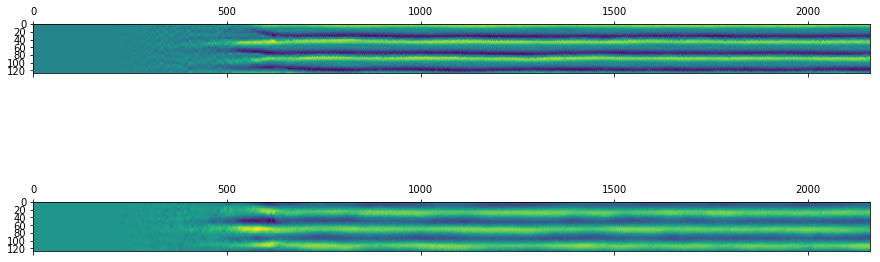

In [2]:
fig, ax = plt.subplots(2,figsize=(15,6))
ax[0].matshow(q_zonal_mean[:,:,0].T)
ax[1].matshow(q_zonal_mean[:,:,1].T)

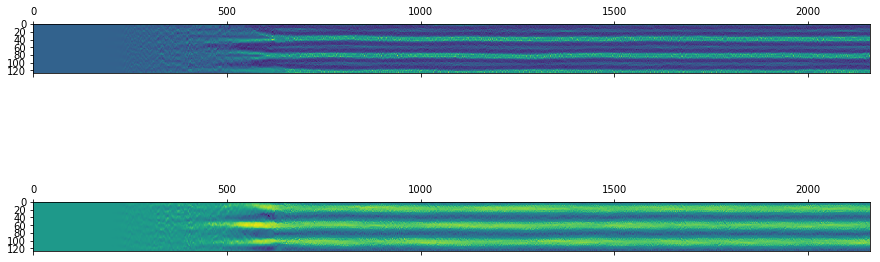

In [3]:
fig, ax = plt.subplots(2,figsize=(15,6))
ax[0].matshow(dq_zonal_mean[:,:,0].T)
ax[1].matshow(dq_zonal_mean[:,:,1].T)

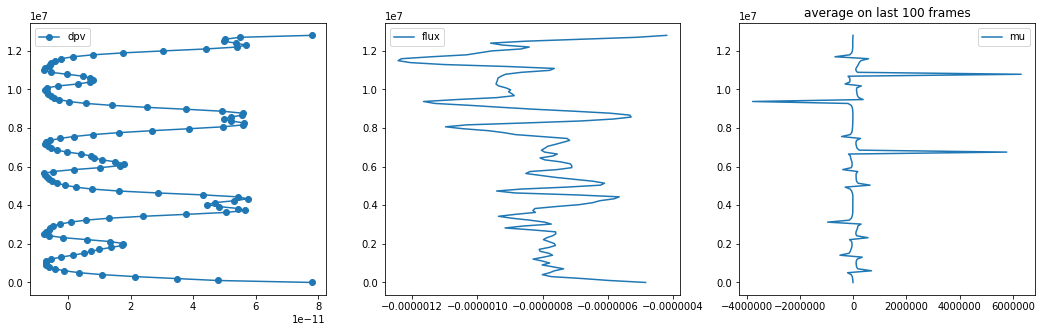

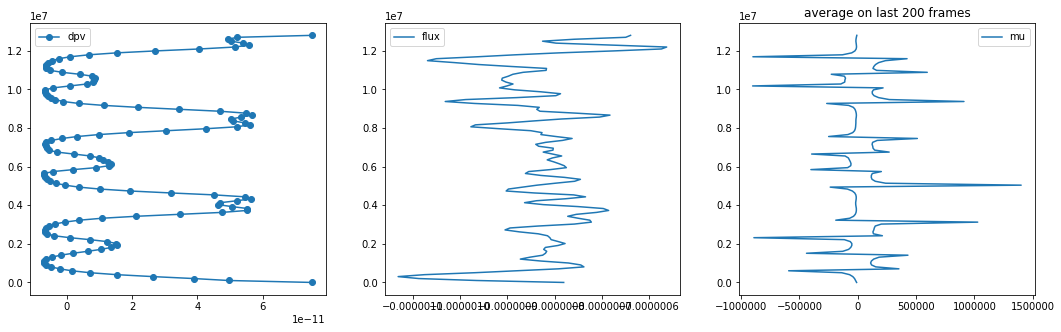

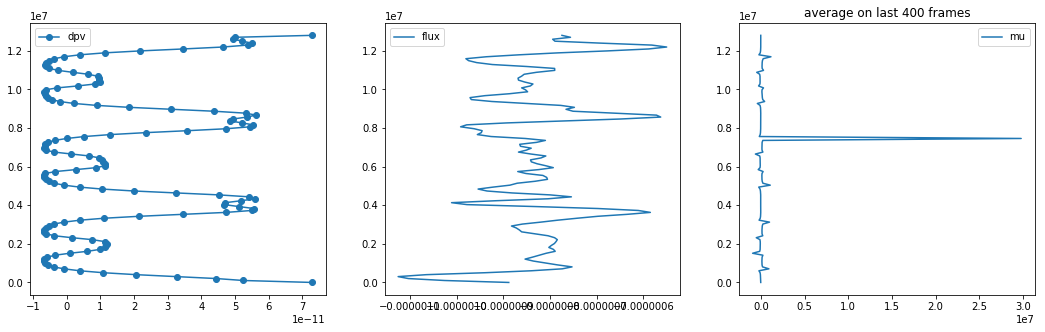

In [4]:
clipping = 1.0
for i in [100,200,400]:
    t_mean_steps = range(-i,-1)
    flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
    dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :], axis = 0)
    q_mean       = np.mean(q_zonal_mean[t_mean_steps, :, :], axis = 0)

    # clipping 
    # dpv_mean[np.logical_and(dpv_mean >=-clipping , dpv_mean <= 0.0)] = -clipping
    # dpv_mean[np.logical_and(dpv_mean <= clipping , dpv_mean >= 0.0)] =  clipping

    mu_mean = flux_mean / dpv_mean
    fig, ax = plt.subplots(1,3,figsize=(18,5))
    ax[0].plot(dpv_mean[:, 0], yy, "-o", label="dpv")
    ax[1].plot(flux_mean[:, 0], yy, label="flux")
    ax[2].plot(mu_mean[:, 0], yy, label="mu")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.title("average on last %d frames" %i)

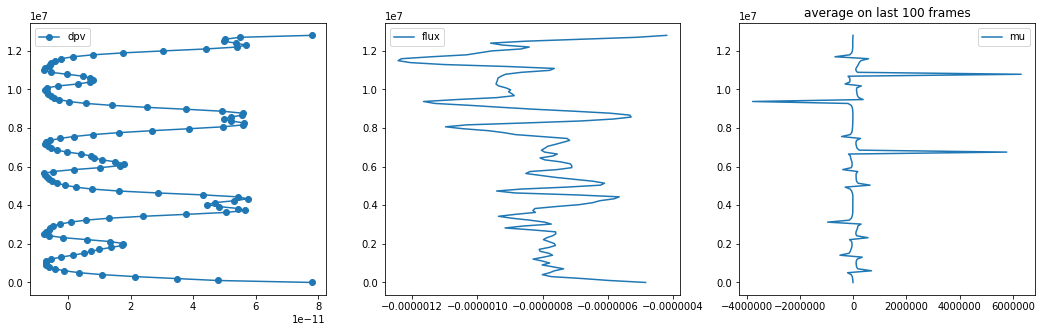

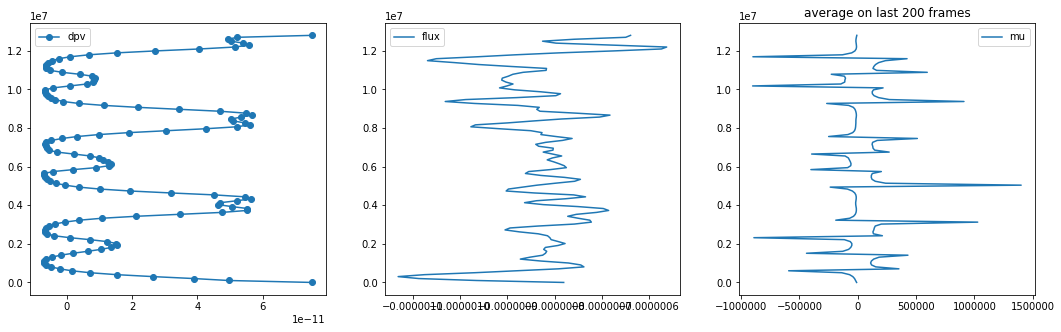

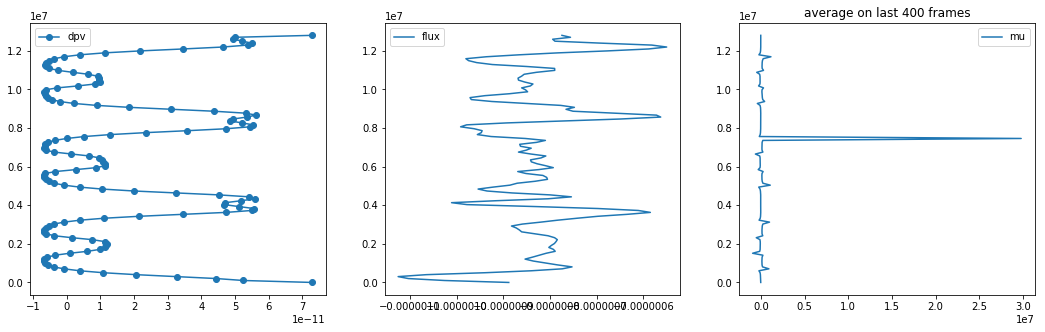

In [5]:
for i in [100,200,400]:
    t_mean_steps = range(-i,-1)
    flux_mean    = np.mean(flux_zonal_mean[t_mean_steps, :, :], axis = 0)
    dpv_mean     = np.mean(dpv_zonal_mean[t_mean_steps, :, :], axis = 0)
    q_mean       = np.mean(q_zonal_mean[t_mean_steps, :, :], axis = 0)

    mu_mean = flux_mean / dpv_mean
    fig, ax = plt.subplots(1,3,figsize=(18,5))
    ax[0].plot(dpv_mean[:, 0], yy, "-o", label="dpv")
    ax[1].plot(flux_mean[:, 0], yy, label="flux")
    ax[2].plot(mu_mean[:, 0], yy, label="mu")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.title("average on last %d frames" %i)

1 max q 9.998445319977634e-08
2 max q 9.997331236736327e-08
3 max q 9.996317648388e-08
4 max q 9.995328523826249e-08
5 max q 9.994332550976401e-08
6 max q 9.993363057928832e-08
7 max q 9.992405207825914e-08
8 max q 9.991471779754565e-08
9 max q 9.990555180640187e-08
10 max q 9.989660093547349e-08
11 max q 9.988782258318677e-08
12 max q 9.987923100333973e-08
13 max q 9.987080005827986e-08
14 max q 9.986253098832237e-08
15 max q 9.985440645835023e-08
16 max q 9.984642279835325e-08
17 max q 9.98385677467939e-08
18 max q 9.983083609832507e-08
19 max q 9.98232187171857e-08
20 max q 9.981571023997577e-08
21 max q 9.980830357319395e-08
22 max q 9.980099372010441e-08
23 max q 9.979377499358687e-08
24 max q 9.97866429267837e-08
25 max q 9.977959284773052e-08
26 max q 9.977262083408065e-08
27 max q 9.976572297726572e-08
28 max q 9.97588958577228e-08
29 max q 9.975213616082719e-08
30 max q 9.974793449152763e-08
31 max q 9.974452552306916e-08
32 max q 9.974107405832584e-08
33 max q 9.9737583175111

350 max q 9.868929739055012e-08
351 max q 9.868652989440951e-08
352 max q 9.868376115425318e-08
353 max q 9.86809911823829e-08
354 max q 9.867821999104236e-08
355 max q 9.867544759241721e-08
356 max q 9.867267399863519e-08
357 max q 9.866989922176618e-08
358 max q 9.866712327382235e-08
359 max q 9.866434616675822e-08
360 max q 9.866156791247073e-08
361 max q 9.865878852279937e-08
362 max q 9.865600800952627e-08
363 max q 9.865322638437629e-08
364 max q 9.865044365901712e-08
365 max q 9.864765984505935e-08
366 max q 9.864487495405662e-08
367 max q 9.864208899750568e-08
368 max q 9.86393019868465e-08
369 max q 9.863651393346235e-08
370 max q 9.863372484867996e-08
371 max q 9.863093474376956e-08
372 max q 9.862814362994501e-08
373 max q 9.862535151836392e-08
374 max q 9.862255842012769e-08
375 max q 9.86197643462817e-08
376 max q 9.86169693078154e-08
377 max q 9.861417331566234e-08
378 max q 9.86113763807004e-08
379 max q 9.860857851375178e-08
380 max q 9.860577972558319e-08
381 max q 9.8

699 max q 9.778324850670461e-08
700 max q 9.778107589233138e-08
701 max q 9.77789028088496e-08
702 max q 9.777672925936822e-08
703 max q 9.7774555246981e-08
704 max q 9.77723807747665e-08
705 max q 9.77702058457882e-08
706 max q 9.776803046309453e-08
707 max q 9.776585462971893e-08
708 max q 9.776367834867992e-08
709 max q 9.776150162298117e-08
710 max q 9.775932445561154e-08
711 max q 9.775714684954515e-08
712 max q 9.775496880774144e-08
713 max q 9.775279033314523e-08
714 max q 9.775061142868675e-08
715 max q 9.774843209728178e-08
716 max q 9.77462523418316e-08
717 max q 9.774407216522316e-08
718 max q 9.774189157032903e-08
719 max q 9.773971056000756e-08
720 max q 9.773752913710284e-08
721 max q 9.773534730444485e-08
722 max q 9.773316506484946e-08
723 max q 9.773098242111851e-08
724 max q 9.772879937603987e-08
725 max q 9.772661593238746e-08
726 max q 9.772443209292135e-08
727 max q 9.772224786038783e-08
728 max q 9.77200632375194e-08
729 max q 9.771787822703491e-08
730 max q 9.771

1048 max q 9.701125149183041e-08
1049 max q 9.700902695680388e-08
1050 max q 9.700680244009319e-08
1051 max q 9.700457794205954e-08
1052 max q 9.700235346306098e-08
1053 max q 9.700012900345239e-08
1054 max q 9.699790456358544e-08
1055 max q 9.699568014380873e-08
1056 max q 9.699345574446767e-08
1057 max q 9.699123136590456e-08
1058 max q 9.698900700845865e-08
1059 max q 9.698678267246606e-08
1060 max q 9.698455835825984e-08
1061 max q 9.698233406617001e-08
1062 max q 9.698010979652354e-08
1063 max q 9.697788554964437e-08
1064 max q 9.697566132585344e-08
1065 max q 9.697343712546868e-08
1066 max q 9.697121294880504e-08
1067 max q 9.696898879617453e-08
1068 max q 9.696676466788616e-08
1069 max q 9.696454056424603e-08
1070 max q 9.696231648555732e-08
1071 max q 9.69600924321203e-08
1072 max q 9.695786840423232e-08
1073 max q 9.695564440218788e-08
1074 max q 9.695342042627859e-08
1075 max q 9.695119647679321e-08
1076 max q 9.694897255401764e-08
1077 max q 9.694674865823501e-08
1078 max q 

1396 max q 9.623932382226347e-08
1397 max q 9.623711229280812e-08
1398 max q 9.623490079133943e-08
1399 max q 9.623268931770648e-08
1400 max q 9.623047787175794e-08
1401 max q 9.622826645334207e-08
1402 max q 9.622605506230674e-08
1403 max q 9.622384369849945e-08
1404 max q 9.622163236176726e-08
1405 max q 9.621942105195687e-08
1406 max q 9.62172097689146e-08
1407 max q 9.621499851248639e-08
1408 max q 9.621278728251778e-08
1409 max q 9.621057607885393e-08
1410 max q 9.620836490133968e-08
1411 max q 9.620615374981945e-08
1412 max q 9.620394262413732e-08
1413 max q 9.620173152413701e-08
1414 max q 9.619952044966186e-08
1415 max q 9.619730940055489e-08
1416 max q 9.619509837665874e-08
1417 max q 9.61928873778157e-08
1418 max q 9.619067640386776e-08
1419 max q 9.618846545465652e-08
1420 max q 9.618625453002325e-08
1421 max q 9.61840436298089e-08
1422 max q 9.618183275385409e-08
1423 max q 9.617962190199908e-08
1424 max q 9.617741107408384e-08
1425 max q 9.617520026994801e-08
1426 max q 9.

1746 max q 9.552903292124803e-08
1747 max q 9.552721969555016e-08
1748 max q 9.552540629943657e-08
1749 max q 9.55235927328063e-08
1750 max q 9.552177899555824e-08
1751 max q 9.551996508759119e-08
1752 max q 9.551815100880377e-08
1753 max q 9.551633675909451e-08
1754 max q 9.551452233836178e-08
1755 max q 9.551270774650386e-08
1756 max q 9.551089298341886e-08
1757 max q 9.550907804900482e-08
1758 max q 9.55072629431596e-08
1759 max q 9.550544766578099e-08
1760 max q 9.550363221676664e-08
1761 max q 9.55018165960141e-08
1762 max q 9.550000080342078e-08
1763 max q 9.549818483888402e-08
1764 max q 9.5496368702301e-08
1765 max q 9.549455239356884e-08
1766 max q 9.549273591258452e-08
1767 max q 9.549091925924492e-08
1768 max q 9.548910243344682e-08
1769 max q 9.548728543508693e-08
1770 max q 9.548546826406181e-08
1771 max q 9.548365092026796e-08
1772 max q 9.548183340360175e-08
1773 max q 9.548001571395949e-08
1774 max q 9.547819785123738e-08
1775 max q 9.547637981533155e-08
1776 max q 9.54

2095 max q 9.488514023490733e-08
2096 max q 9.488326132844823e-08
2097 max q 9.488138221760295e-08
2098 max q 9.487950290229661e-08
2099 max q 9.487762338245459e-08
2100 max q 9.48757436580024e-08
2101 max q 9.487386372886579e-08
2102 max q 9.487198359497071e-08
2103 max q 9.487010325624327e-08
2104 max q 9.486822271260984e-08
2105 max q 9.486634196399691e-08
2106 max q 9.486446101033123e-08
2107 max q 9.486257985153975e-08
2108 max q 9.486069848754957e-08
2109 max q 9.485881691828802e-08
2110 max q 9.485693514368263e-08
2111 max q 9.485505316366113e-08
2112 max q 9.485317097815145e-08
2113 max q 9.485128858708172e-08
2114 max q 9.484940599038025e-08
2115 max q 9.484752318797561e-08
2116 max q 9.48456401797965e-08
2117 max q 9.484375696577187e-08
2118 max q 9.484187354583084e-08
2119 max q 9.483998991990275e-08
2120 max q 9.483810608791716e-08
2121 max q 9.483622204980379e-08
2122 max q 9.483433780549262e-08
2123 max q 9.483245335491377e-08
2124 max q 9.48305686979976e-08
2125 max q 9.

2438 max q 9.422830722892684e-08
2439 max q 9.422635523629566e-08
2440 max q 9.422440302610093e-08
2441 max q 9.422245059834121e-08
2442 max q 9.42204979530153e-08
2443 max q 9.421854509012216e-08
2444 max q 9.421659200966098e-08
2445 max q 9.421463871163117e-08
2446 max q 9.42126851960323e-08
2447 max q 9.421073146286418e-08
2448 max q 9.420877751212685e-08
2449 max q 9.420682334382048e-08
2450 max q 9.420486895794552e-08
2451 max q 9.420291435450258e-08
2452 max q 9.420095953349247e-08
2453 max q 9.419900449491624e-08
2454 max q 9.419704923877512e-08
2455 max q 9.419509376507054e-08
2456 max q 9.419313807380415e-08
2457 max q 9.41911821649778e-08
2458 max q 9.418922603859352e-08
2459 max q 9.418726969465358e-08
2460 max q 9.418531313316042e-08
2461 max q 9.418335635411672e-08
2462 max q 9.418139935752532e-08
2463 max q 9.417944214338929e-08
2464 max q 9.417748471171188e-08
2465 max q 9.417552706249658e-08
2466 max q 9.417356919574704e-08
2467 max q 9.417161111146715e-08
2468 max q 9.

2787 max q 9.375466570799313e-08
2788 max q 9.37538354667488e-08
2789 max q 9.375300543769932e-08
2790 max q 9.375217562075092e-08
2791 max q 9.375134601580983e-08
2792 max q 9.375051662278233e-08
2793 max q 9.37496874415747e-08
2794 max q 9.374885847209323e-08
2795 max q 9.374802971424423e-08
2796 max q 9.374720116793401e-08
2797 max q 9.374637283306893e-08
2798 max q 9.374554470955536e-08
2799 max q 9.374471679729966e-08
2800 max q 9.374388909620823e-08
2801 max q 9.374306160618748e-08
2802 max q 9.374223432714385e-08
2803 max q 9.374140725898379e-08
2804 max q 9.374058040161374e-08
2805 max q 9.37397537549402e-08
2806 max q 9.373892731886966e-08
2807 max q 9.373810109330863e-08
2808 max q 9.373727507816365e-08
2809 max q 9.373644927334126e-08
2810 max q 9.373562367874805e-08
2811 max q 9.373479829429058e-08
2812 max q 9.373397311987547e-08
2813 max q 9.373314815540933e-08
2814 max q 9.373232340079881e-08
2815 max q 9.373149885595056e-08
2816 max q 9.373067452077125e-08
2817 max q 9.

3136 max q 9.347715096970191e-08
3137 max q 9.347638923892247e-08
3138 max q 9.347562768897735e-08
3139 max q 9.347486631978143e-08
3140 max q 9.347410513124963e-08
3141 max q 9.347334412329687e-08
3142 max q 9.347258329583812e-08
3143 max q 9.34718226487884e-08
3144 max q 9.347106218206273e-08
3145 max q 9.347030189557618e-08
3146 max q 9.346954178924383e-08
3147 max q 9.346878186298079e-08
3148 max q 9.346802211670224e-08
3149 max q 9.346726255032335e-08
3150 max q 9.346650316375934e-08
3151 max q 9.346574395692545e-08
3152 max q 9.346498492973694e-08
3153 max q 9.346422608210915e-08
3154 max q 9.346346741395737e-08
3155 max q 9.3462708925197e-08
3156 max q 9.346195061574343e-08
3157 max q 9.346119248551207e-08
3158 max q 9.346043453441841e-08
3159 max q 9.345967676237791e-08
3160 max q 9.34589191693061e-08
3161 max q 9.345816175511852e-08
3162 max q 9.345740451973077e-08
3163 max q 9.345664746305845e-08
3164 max q 9.34558905850172e-08
3165 max q 9.345513388552268e-08
3166 max q 9.34

3486 max q 9.322100577377903e-08
3487 max q 9.322030235843905e-08
3488 max q 9.321959909607016e-08
3489 max q 9.32188959865984e-08
3490 max q 9.321819302994987e-08
3491 max q 9.321749022605068e-08
3492 max q 9.321678757482697e-08
3493 max q 9.321608507620493e-08
3494 max q 9.321538273011077e-08
3495 max q 9.321468053647072e-08
3496 max q 9.321397849521108e-08
3497 max q 9.321327660625814e-08
3498 max q 9.321257486953825e-08
3499 max q 9.321187328497778e-08
3500 max q 9.321117185250314e-08
3501 max q 9.321047057204076e-08
3502 max q 9.320976944351713e-08
3503 max q 9.320906846685873e-08
3504 max q 9.320836764199212e-08
3505 max q 9.320766696884386e-08
3506 max q 9.320696644734054e-08
3507 max q 9.32062660774088e-08
3508 max q 9.32055658589753e-08
3509 max q 9.320486579196673e-08
3510 max q 9.320416587630984e-08
3511 max q 9.320346611193138e-08
3512 max q 9.320276649875815e-08
3513 max q 9.320206703671698e-08
3514 max q 9.320136772573472e-08
3515 max q 9.320066856573826e-08
3516 max q 9.

3833 max q 9.298659007517745e-08
3834 max q 9.298595342354982e-08
3835 max q 9.298531690393529e-08
3836 max q 9.298468051625746e-08
3837 max q 9.298404426044003e-08
3838 max q 9.298340813640675e-08
3839 max q 9.298277214408136e-08
3840 max q 9.298213628338773e-08
3841 max q 9.298150055424973e-08
3842 max q 9.298086495659129e-08
3843 max q 9.29802294903364e-08
3844 max q 9.29795941554091e-08
3845 max q 9.297895895173347e-08
3846 max q 9.297832387923364e-08
3847 max q 9.29776889378338e-08
3848 max q 9.297705412745818e-08
3849 max q 9.297641944803107e-08
3850 max q 9.297578489947682e-08
3851 max q 9.297515048171979e-08
3852 max q 9.297451619468441e-08
3853 max q 9.297388203829518e-08
3854 max q 9.297324801247664e-08
3855 max q 9.297261411715338e-08
3856 max q 9.297198035225001e-08
3857 max q 9.297134671769122e-08
3858 max q 9.297071321340176e-08
3859 max q 9.297007983930639e-08
3860 max q 9.296944659532997e-08
3861 max q 9.296881348139735e-08
3862 max q 9.296818049743347e-08
3863 max q 9.

4181 max q 9.277250301895045e-08
4182 max q 9.27719080269138e-08
4183 max q 9.277131314311629e-08
4184 max q 9.277071836749704e-08
4185 max q 9.277012369999521e-08
4186 max q 9.276952914055002e-08
4187 max q 9.276893468910068e-08
4188 max q 9.276834034558647e-08
4189 max q 9.276774610994672e-08
4190 max q 9.276715198212078e-08
4191 max q 9.276655796204805e-08
4192 max q 9.276596404966795e-08
4193 max q 9.276537024491995e-08
4194 max q 9.276477654774357e-08
4195 max q 9.276418295807837e-08
4196 max q 9.27635894758639e-08
4197 max q 9.276299610103983e-08
4198 max q 9.27624028335458e-08
4199 max q 9.276180967332153e-08
4200 max q 9.276121662030675e-08
4201 max q 9.276062367444125e-08
4202 max q 9.276003083566485e-08
4203 max q 9.27594381039174e-08
4204 max q 9.27588454791388e-08
4205 max q 9.275825296126898e-08
4206 max q 9.275766055024793e-08
4207 max q 9.275706824601565e-08
4208 max q 9.275647604851219e-08
4209 max q 9.275588395767766e-08
4210 max q 9.275529197345216e-08
4211 max q 9.27

4529 max q 9.257157946607493e-08
4530 max q 9.257101872149691e-08
4531 max q 9.25704580661472e-08
4532 max q 9.256989749997697e-08
4533 max q 9.256933702293739e-08
4534 max q 9.256877663497969e-08
4535 max q 9.256821633605511e-08
4536 max q 9.256765612611494e-08
4537 max q 9.256709600511048e-08
4538 max q 9.256653597299309e-08
4539 max q 9.256597602971413e-08
4540 max q 9.2565416175225e-08
4541 max q 9.256485640947713e-08
4542 max q 9.256429673242199e-08
4543 max q 9.256373714401107e-08
4544 max q 9.256317764419589e-08
4545 max q 9.256261823292801e-08
4546 max q 9.256205891015901e-08
4547 max q 9.256149967584051e-08
4548 max q 9.256094052992414e-08
4549 max q 9.256038147236158e-08
4550 max q 9.255982250310453e-08
4551 max q 9.255926362210474e-08
4552 max q 9.255870482931396e-08
4553 max q 9.255814612468399e-08
4554 max q 9.255758750816665e-08
4555 max q 9.25570289797138e-08
4556 max q 9.255647053927731e-08
4557 max q 9.255591218680912e-08
4558 max q 9.255535392226115e-08
4559 max q 9.2

4877 max q 9.238150513438423e-08
4878 max q 9.238097269244874e-08
4879 max q 9.238044032444637e-08
4880 max q 9.237990803033772e-08
4881 max q 9.23793758100834e-08
4882 max q 9.237884366364406e-08
4883 max q 9.237831159098034e-08
4884 max q 9.237777959205294e-08
4885 max q 9.237724766682255e-08
4886 max q 9.237671581524992e-08
4887 max q 9.23761840372958e-08
4888 max q 9.237565233292097e-08
4889 max q 9.237512070208622e-08
4890 max q 9.237458914475241e-08
4891 max q 9.237405766088037e-08
4892 max q 9.237352625043097e-08
4893 max q 9.237299491336512e-08
4894 max q 9.237246364964375e-08
4895 max q 9.237193245922779e-08
4896 max q 9.237140134207821e-08
4897 max q 9.237087029815603e-08
4898 max q 9.237033932742224e-08
4899 max q 9.236980842983788e-08
4900 max q 9.236927760536404e-08
4901 max q 9.23687468539618e-08
4902 max q 9.236821617559226e-08
4903 max q 9.236768557021656e-08
4904 max q 9.236715503779587e-08
4905 max q 9.236662457829136e-08
4906 max q 9.236609419166425e-08
4907 max q 9.

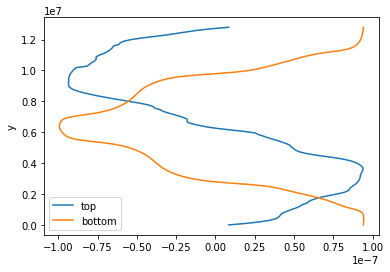

In [17]:
run Solver_q.py

In [8]:
q_data.shape

(1001, 2, 128)

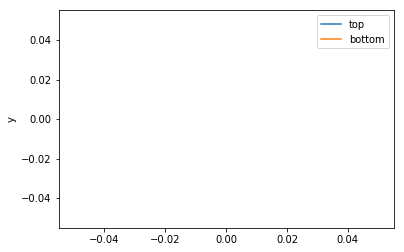

In [9]:
plt.figure()
plt.plot(np.mean(q_data[:, 0, :], axis=0), yy,  label="top")
plt.plot(np.mean(q_data[:, 1, :], axis=0), yy,  label="bottom")


plt.ylabel("y")
plt.legend()
plt.show()

In [23]:
q_data[0, :, :].shape

(2, 128)